In [2]:
from tcn import TCN
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import dump
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

In [3]:
X_train = pd.read_csv("../../../Split Data/Training Dataset/X_train #1.csv").drop(columns=["Unnamed: 0"])
y_train = pd.read_csv("../../../Split Data/Training Dataset/y_train #1.csv", index_col=0)
X_val = pd.read_csv("../../../Split Data/Validation Dataset/X_val #1.csv").drop(columns=["Unnamed: 0"])
y_val = pd.read_csv("../../../Split Data/Validation Dataset/y_val #1.csv", index_col=0)
X_test = pd.read_csv("../../../Split Data/Testing Dataset/X_test #1.csv").drop(columns=["Unnamed: 0"])
y_test = pd.read_csv("../../../Split Data/Testing Dataset/y_test #1.csv", index_col=0)

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)   
X_test_scaled = scaler.transform(X_test) 

In [5]:
X_train = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)  
X_val = np.array(X_val_scaled).reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)  
X_test = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)  

In [6]:
num_classes = 2   
kernel_size = 5
dilations = [4, 8, 16, 32, 64] 
max_len = X_train.shape[1] 
dropout_rate = 0.05

In [7]:
inputs = Input(shape=(max_len, 1))

In [8]:
tcn = TCN(
    nb_filters= 128,
    nb_stacks = 2,
    kernel_size=kernel_size,
    dilations=dilations,
    dropout_rate=dropout_rate,
    use_layer_norm=True,
    return_sequences = True
)(inputs)

2025-04-27 01:21:48.007186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 01:21:48.380695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 01:21:48.383216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [10]:
max_pooling = GlobalMaxPooling1D()(tcn)

In [11]:
avg_pooling = GlobalAveragePooling1D()(tcn)

In [12]:
pooling = Concatenate()([max_pooling, avg_pooling])

In [13]:
dense1 = Dense(64, activation= 'relu')(pooling)

In [14]:
dropout1 = Dropout(0.2)(dense1)

In [15]:
outputs = Dense(2, activation='softmax')(dropout1)

In [16]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [17]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11, 1)]              0         []                            
                                                                                                  
 tcn (TCN)                   (None, 11, 128)              1565056   ['input_1[0][0]']             
                                                                                                  
 global_max_pooling1d (Glob  (None, 128)                  0         ['tcn[0][0]']                 
 alMaxPooling1D)                                                                                  
                                                                                                  
 global_average_pooling1d (  (None, 128)                  0         ['tcn[0][0]']             

In [18]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

y_train shape: (315123, 2)
y_val shape: (67526, 2)


In [19]:
history = model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val), verbose = 1, 
          callbacks = 
          [ModelCheckpoint(filepath="TCN #1.h5", 
          monitor='val_f1', mode='max',save_best_only=True), 
          EarlyStopping(monitor='val_f1', patience =5, 
          restore_best_weights= True, mode ="max")], 
          batch_size = 128)

Epoch 1/100


2025-04-27 01:22:11.913350: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-04-27 01:22:14.759677: I external/local_xla/xla/service/service.cc:168] XLA service 0x77cb6b560f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-27 01:22:14.759724: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-27 01:22:14.799158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745716935.039627   30784 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2462/2462 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.8494 - f1: 0.8494

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2462/2462 [==============================] - 156s 54ms/step - loss: 0.3778 - accuracy: 0.8494 - f1: 0.8494 - val_loss: 0.3379 - val_accuracy: 0.8630 - val_f1: 0.8630
Epoch 2/100
2462/2462 [==============================] - 128s 52ms/step - loss: 0.3449 - accuracy: 0.8614 - f1: 0.8614 - val_loss: 0.3400 - val_accuracy: 0.8648 - val_f1: 0.8648
Epoch 3/100
2462/2462 [==============================] - 128s 52ms/step - loss: 0.3396 - accuracy: 0.8625 - f1: 0.8625 - val_loss: 0.3331 - val_accuracy: 0.8622 - val_f1: 0.8622
Epoch 4/100
2462/2462 [==============================] - 127s 52ms/step - loss: 0.3364 - accuracy: 0.8634 - f1: 0.8634 - val_loss: 0.3299 - val_accuracy: 0.8645 - val_f1: 0.8645
Epoch 5/100
2462/2462 [==============================] - 127s 52ms/step - loss: 0.3347 - accuracy: 0.8641 - f1: 0.8641 - val_loss: 0.3299 - val_accuracy: 0.8656 - val_f1: 0.8656
Epoch 6/100
2462/2462 [==============================] - 126s 51ms/step - loss: 0.3333 - accuracy: 0.8644 - f1: 0.8644 - v

In [20]:
TCN_model = load_model('TCN #1.h5', custom_objects={'f1': f1})

In [21]:
y_test = to_categorical(y_test, 2)

In [22]:
results = TCN_model.evaluate(X_test, y_test, verbose = 1)

2111/2111 [==============================] - 33s 15ms/step - loss: 0.3242 - accuracy: 0.8676 - f1: 0.8676


In [23]:
y_pred = TCN_model.predict(X_test)

2111/2111 [==============================] - 33s 15ms/step


In [24]:
y_test = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

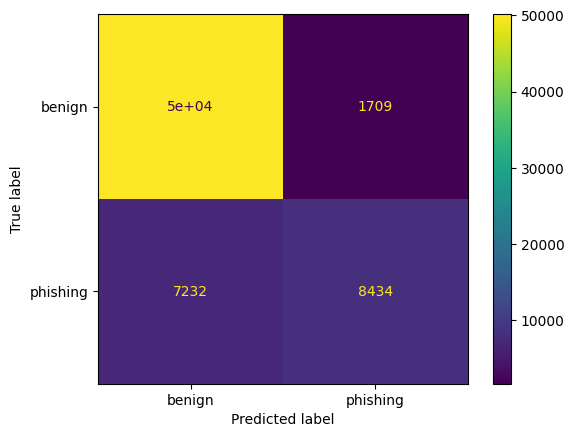

In [26]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["benign", "phishing"])                            
matrix.plot()

In [27]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
F1_score = metrics.f1_score(y_test, y_pred)

In [28]:
print({"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"F1_score":F1_score})

{'Accuracy': 0.867593703259437, 'Precision': 0.8315094153603471, 'Recall': 0.5383633346099834, 'F1_score': 0.6535704599170832}


In [29]:
df = pd.read_csv("../Metrics of Dataset #1.csv")

In [30]:
metrics = pd.DataFrame({"Model": "TCN", "Accuracy": [Accuracy], "Precision":[Precision], "Recall": [Recall], "F1_score": [F1_score]})

In [31]:
df = pd.concat([df, metrics], ignore_index=True)

In [32]:
df.head()

,Model,Accuracy,Precision,Recall,F1_score
0,LinearSVC,0.796126,0.834921,0.151092,0.255878
1,Random Forest,0.870822,0.871482,0.519852,0.651233
2,XGBoost,0.865624,0.873951,0.491702,0.629330
3,MLP,0.870141,0.873255,0.515001,0.647902
4,TCN,0.867594,0.831509,0.538363,0.653570


In [33]:
df.to_csv("../Metrics of Dataset #1.csv", index=False)